# Introduction

    In this notebook, we look at how the approximants are modified when the window is shifted in internal space (phason shiiifts here we come!). The C&P framework is used (as opposed to the inflation framework).

In [1]:
import sys
sys.path.insert(0, '../Tilings') # prepend the path to the Tiling package

import CP as CP
import QuantumGraph as QGraph

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

import networkx as nx

import scipy.linalg
from scipy.sparse.linalg import eigsh

import itertools

# interactivity in the notebook
from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

# replace by %matplotlib notebook for full interactivity (but beware of the flickering!)
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0)

* We say that the window is in a *singular position* if there are lattice points at the boundary of the window.
* We say that the window is in a *standard position* if it is in a singular position, and if the center of the window is at a minimal distance from 0. 

For a given approximant, there are 4 choices of standard positions forming a square around 0.
We will always chose by convention the standard position that places the center of the window at the south east of the point 0.

In [2]:
# basis of Z4
e = np.identity(4, dtype=int)

def o(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + 2*b
    return a

def norm(n):
    return np.sqrt(8.*o(n)**2+2.*(-1)**n)

def vecs(n):
    """
    return the generating vectors of the internal space lattice
    """
    return np.array([[-1.,1.],[1.,1.]])/norm(n)

def center(n):
    """
    distance between the (0,0,0,0) lattice point and the center of the window in standard position
    """
    a, b = vecs(n)
    return ((-1)**(n+1)*a-b)/2.

def window(n):
    """
    return the eight vertices of the window
    """
    o1 = o(n)
    o2  =o(n+1)
    return np.array([[o1,o2],[-o1,o2],[-o2,o1],[-o2,-o1],[-o1,-o2],[o1,-o2],[o2,-o1],[o2,o1]])/norm(n)

def draw_window(ax, n, center):
    """
    Draw on axis ax the window of the nth approximant
    """
    verts = list(window(n) - center) + [[0,0]]

    codes = [Path.MOVETO] + [Path.LINETO for x in range(len(verts)-2)] + [Path.CLOSEPOLY]
    path = Path(verts, codes)

    patch = patches.PathPatch(path, facecolor='orange', lw=1, alpha=0.5)
    ax.add_patch(patch)
    ax.set_xlim(-1.1 - center[0],1.1 - center[0])
    ax.set_ylim(-1.1 - center[1],1.1 - center[1])
    ax.set_aspect('equal')

In [6]:
Lx = 10.
Ly = 10.
def square_region(p):
    x, y = p
    return  abs(x) <= 0.5*Lx and abs(y) <= 0.5*Ly

def compute_graph(n, orig, region = square_region, p0 = (0,0,0,0)):
    """
    Compute the tiling of a small region, were the origin of the window is shifted along e[2]
    """
    # initialization of the tiling
    r = CP.ABP(n, orig)
    # set the physical space region we want the points in
    r.in_region = region

    # translate p0 by e[2] until it falls inside the window
    p0perp = np.dot(r._perp, p0)
    while not r.in_window(p0perp):
        p0 -= e[2]
        p0perp = np.dot(r._perp, p0)

    return r.compute_graph(p0)

def plot(n, shift):
    """
    plot the graph of the tiling in perp space, were the origin of the window is shifted along e[2] 
    """
    fig, ax = plt.subplots(1, 2)

    # origin of the shifted window
    orig = -center(n) + shift*np.array([0.,1.])
    # draw the initial window
    draw_window(ax[0], n, center(n)) 
    # draw the corresponding window
    draw_window(ax[0], n, -orig)
    # compute the tiling graph
    g = compute_graph(n, orig)
    # draw the tiling points
    ax[0].set_xlim((-1.5,1.5))
    ax[0].set_ylim((-1.2,3.))
    perp_pos = nx.get_node_attributes(g, 'perp')
    nx.draw_networkx(g, perp_pos, with_labels = False, node_size = 10., width = 1., ax = ax[0])
    
    para_pos = nx.get_node_attributes(g, 'para')
    ax[1].set_aspect('equal')
    nx.draw_networkx(g, para_pos, with_labels = False, node_size = 0., width = 1., ax = ax[1])
    

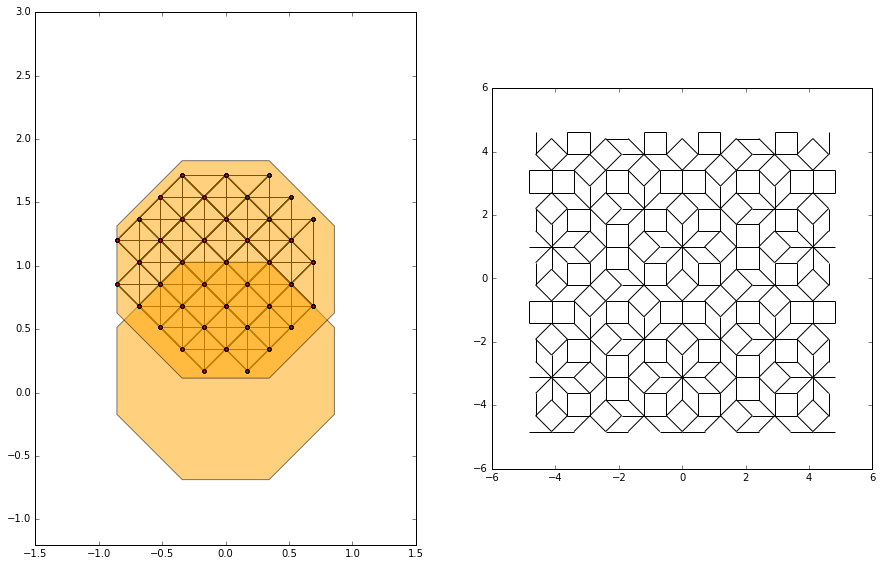

In [7]:
w = interactive(plot, n=2, shift=(0.,1.72))
display(w)

After translating the window of 1 window length upwards, the tiling is back in the same configuration, but every node is translated by $\pi_\parallel(e_3 - e_2 + e_1)$.

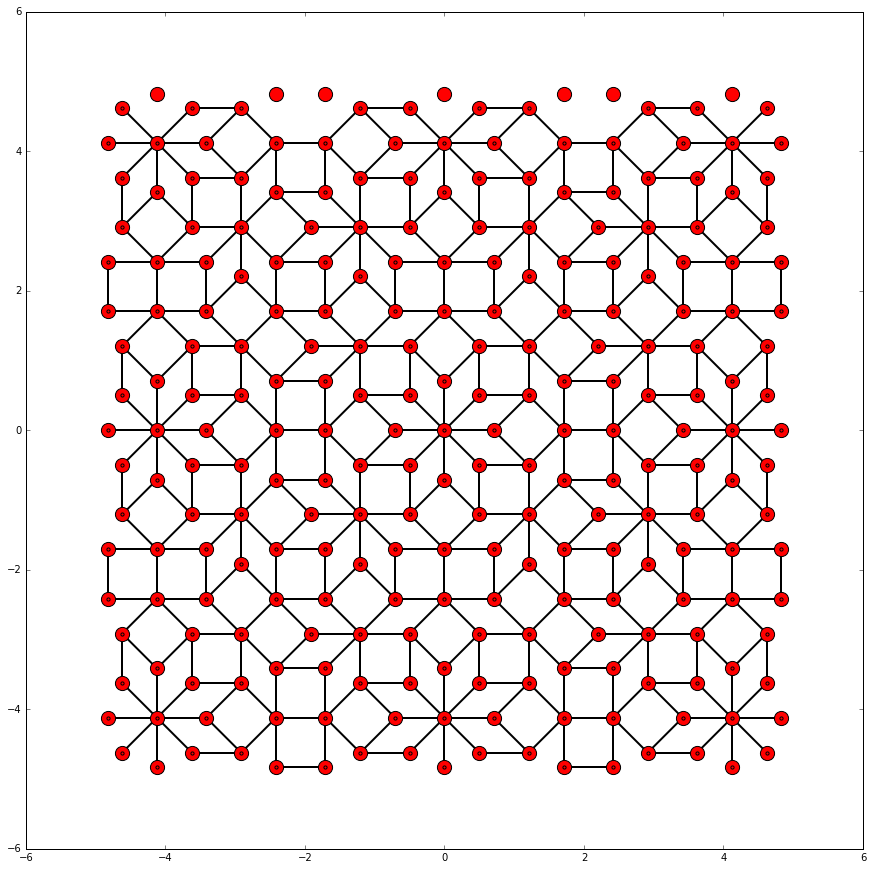

In [46]:
n = 2 # number of inflations
e = np.identity(4, dtype=int) # basis of Z4
t0 = (0, .1) # initial internal space shift
# initial tiling
gi = compute_graph(n, t0)
# length of the window (ie period in internal space)
period = np.dot( CP.ABP(n, (0, 0))._perp, e[3] - e[2] + e[1] )
# shift in real space
realspaceshift = np.dot( CP.ABP(n, (0, 0))._para, e[3] - e[2] + e[1] )
# final tiling
gf = compute_graph(n, t0 + period)

posi = nx.get_node_attributes(gi, 'para')
nx.draw_networkx(gi, posi, with_labels = False, node_size = 200., width = 0.)
posf = nx.get_node_attributes(gf, 'para')
posfshifted = {node:posf[node]-realspaceshift for node in posf}
nx.draw_networkx(gf, posfshifted, with_labels = False, node_size = 10., width = 2.)

# Effect of the window shift on one unit cell

We now isolate one unit cell.
We will perform a window shift along direction $u$ in perp space. We will translate the window for one period, ie $$t_\text{max} = \text{window length along } u$$
The lower left corner of our unit cell will be one point on the line of points (in perp space) that will jump last when the window is translated along $u$.

## Lattice vectors of an approximant
The physical space lattice of the $n^\text{th}$ approximant is a square lattice generated by the vectors
$$
A_n = 
\begin{pmatrix}
	O_{n-1} + O_{n}\\
	O_n\\
	0\\
	-O_n\\
\end{pmatrix}
$$
and
$$
B_n = 
\begin{pmatrix}
	0\\
	O_n\\
	O_{n-1} + O_n\\
	O_n\\
\end{pmatrix}
$$
These vectors are also the (unormalized) line vectors of the matrix $\pi_\parallel^{(n)}: \mathbb{Z}^4 \to E_\parallel^{(n)}$.

We can find the expression of $A_n$ and $B_n$ by iteration.
The $n=0$ approximant has $A_0 = e_0$. Then for the $n=1$ approximant, $A_1 = e_0 +e_1 -e_3$.
By recursion,
$$
A_n = O_n A_1 + O_{n-1} A_0
$$
The same formula holds for $B_n$. From that, we straightforwadly deduce the above expressions for these two vectors.

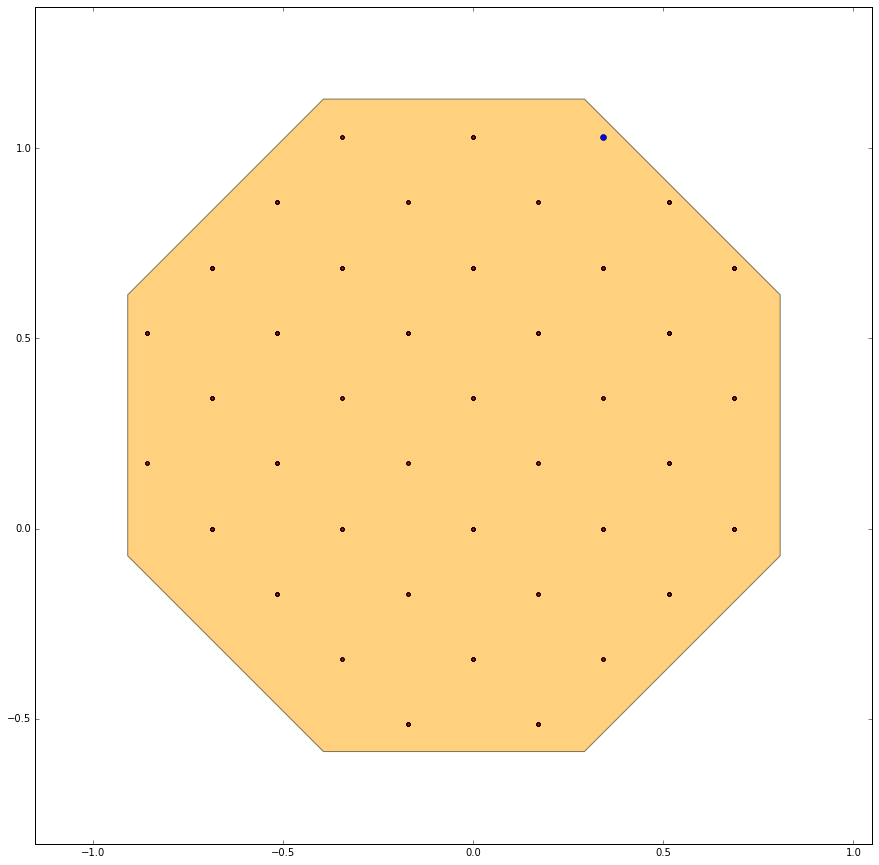

In [47]:
def init_pt(n, orig):
    """ 
    Find a point which has the highest y coordinate in perp space.
    It will be the initial point of our tiling.
    t0 is the shift along y axis wrt to the center of the window in standard position
    """
    # compute
    g0 = compute_graph(n, orig)
    # retrieve the perp pos of the computed tiling points
    perppos = nx.get_node_attributes(g0, 'perp')
    # find the points sitting on top of the window
    ymax = -np.infty
    for p in perppos:
        y = perppos[p][1]
        if y > ymax:
            pmax = p
            ymax = y
    return pmax, g0
    
shift = 0.1
orig = shift*np.array([0.,1.]) - center(n)  - np.array([0.05,0.])
pmax, g0 = init_pt(n, orig)
perppos = nx.get_node_attributes(g0, 'perp')

nx.draw_networkx(g0, perppos, with_labels = False, node_size = 10., width = 0.)
draw_window(plt.axes(), n, -orig)
plt.plot(*perppos[pmax], 'o')

In [7]:
""" iterate the tiling """
# lattice vectors of the para space tiling
def lattice(n):
    a = o(n)
    b = o(n-1)
    return np.array([[a+b,a,0,-a],[0,a,a+b,a]])

def unit_cell(p0, n):
    """
    return a region function delimitating a real space unit cell
    whose lower left corner is the point p0
    """
    A, B = lattice(n)
    # length of the unit cell of the nth approximant
    L = np.dot(CP.ABP(n, (0,0))._para, A)[0]
    # add a small length (smaller than 1/sq(2), the bond length), to account for boundary effects
    L -= 0.1/np.sqrt(2)
    
    def reg(p):
        x, y = p - p0
        return  0 <= x <= L and 0 <= y <= L
    return reg

n = 2
A, B = lattice(n)
shift = 0.1
orig = shift*np.array([0.,1.]) - center(n) - np.array([0.05,0.])
# we choose pmax as the origin of our tiling
pmax, g0 = init_pt(n, orig)
# we set the lower left corner of our real space region to the proj of pmax
p0 = np.dot(CP.ABP(n, (0,0))._para, pmax)
# the function delimitating the real space region
reg = unit_cell(p0, n)
# get the graph
g = compute_graph(n, orig, reg, pmax)

In [8]:
pos = nx.get_node_attributes(g, 'para')
plt.axes().set_aspect("equal")
nx.draw_networkx(g, pos, with_labels = False, node_size = 0., width = 2.)

# draw the lattice points
A, B = lattice(n)
P = CP.ABP(n, (0,0))._para
a = np.dot(P, A)
b = np.dot(P, B)
mm = p0
pm = p0 + a
mp = p0 + b
pp = p0 + a + b
plt.plot(*np.array([mm,mp,pm,pp]).T, 'o')

plt.savefig('unit_cell_per.pdf')
plt.close()
print(len(g))

41


In [9]:
perppos = nx.get_node_attributes(g, 'perp')
nx.draw_networkx(g, perppos, with_labels = False, node_size = 10., width = 0.)
plt.plot(*np.dot(CP.ABP(n, (0,0))._perp, pmax), 'o')
draw_window(plt.axes(), n, -orig)
plt.close()

In [10]:
def graph(n, orig, region = square_region, p0 = (0,0,0,0)):
    """
    Compute the tiling of a small region, were the origin of the window is shifted along e[2]
    """
    # initialization of the tiling
    r = CP.ABP(n, orig)
    # set the physical space region we want the points in
    r.in_region = region
    
    return r.compute_graph(p0)

In [11]:
n = 4
A, B = lattice(n)
shift0 = 0.1
orig = shift*np.array([0.,1.]) - center(n) - np.array([0.05,0.])
# we choose pmax as the origin of our tiling
pmax, g0 = init_pt(n, orig)
# we set the lower left corner of our real space region to the proj of pmax
p0 = np.dot(CP.ABP(n, (0,0))._para, pmax)
# the function delimitating the real space region
reg = unit_cell(p0, n)
# get graphs
vert_shift_graph = lambda shift: graph(n, orig + shift*np.array([0.,1.]), reg, pmax)

In [12]:
# max shift in the vertical direction
smax = np.dot(CP.ABP(n, (0,0))._perp, e[3]-e[2]+e[1])[1] - shift0
# set of shifts we perform. We must be careful not to throw pmax out of the window by a too large shift
shifts = np.arange(0., smax, 1./norm(n))
# compute graphs for all the shifts
graphs = [vert_shift_graph(s) for s in shifts]

In [13]:
# print the graphs
lbl = 0.
for shift, g in zip(shifts, graphs):
    perppos = nx.get_node_attributes(g, 'perp')
    nx.draw_networkx(g, perppos, with_labels = False, node_size = 10., width = 0.)
    plt.plot(*np.dot(CP.ABP(n, (0,0))._perp, pmax), 'o')
    orig = (0.1+shift)*np.array([0.,1.]) - center(n) - np.array([0.05,0.])
    draw_window(plt.axes(), n, -orig)
    plt.savefig('unit_cell_perp_shift_' + str(lbl) + '.png', dpi=200)
    plt.close()
    
    parapos = nx.get_node_attributes(g, 'para')
    nx.draw_networkx(g, parapos, with_labels = False, node_size = 10., width = 2.)
    plt.savefig('unit_cell_para_shift_' + str(lbl) + '.png', dpi=200)
    plt.close()
    
    lbl += 1

In [29]:
# compute the hamiltonian
g0 = graphs[0]
h0 = -1.*nx.to_numpy_matrix(g0, dtype=float)
spec0 = scipy.linalg.eigh(h0, eigvals_only=True)

idx = 0
for g in graphs:
    h = -1.*nx.to_numpy_matrix(g, dtype=float)
    spec = scipy.linalg.eigh(h, eigvals_only=True)
    np.save('data/phason_spectra/free/' +  'gen_' + str(n) + '_shift_' + str(idx), spec)
    idx += 1

In [37]:
# load the spectra
specs = []
for i in range(len(graphs)):
    spec = np.load('data/phason_spectra/free/' +  'gen_' + str(n) + '_shift_' + str(i) + '.npy')
    specs.append(spec)

In [39]:
"""
Plot the DoS
"""

def dos(spec, epsilon, z):
    """
    Compute DoS at energy z with lorenzian broadening epsilon, for spectrum spec
    """
    peaks = epsilon/(((spec - z)**2 + epsilon**2)*np.pi)
    return np.sum(peaks)/len(peaks)
    
idx = 0
for spec in specs:
    # spectral broadening
    eps = 0.004

    # energy range
    N = 3*len(g0)
    erange = np.linspace(-4.4, 4.4, N)

    dos0 = np.array([dos(spec, eps, e) for e in erange])
    plt.plot(erange, dos0, alpha = 0.5)

    plt.ylim((0, 0.2))
    plt.xlim((-2.4, -1.6))
    plt.xlabel('energy')
    plt.ylabel('DoS')
    plt.savefig("spec_"+str(idx)+".png", dpi=150)
    plt.close()
    idx += 1

In [44]:
lattice(4)

array([[ 17,  12,   0, -12],
       [  0,  12,  17,  12]])